<h1><center> Flickr dataset </center></h1>
<center> Robustness_Evaluation model</center>

# I. Prepare places pretrained model

In [1]:
import os
import requests
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from PIL import Image
from torchvision import transforms as trn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from sklearn.metrics import average_precision_score, precision_recall_curve
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader 
from torchsummary import summary
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from transformers import DistilBertModel, DistilBertTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import pickle
from pathlib import Path
import warnings

Purpose: Downloads and prepares the pre-trained Places365 ResNet18 model for context feature extraction.

Essential for initializing the context feature extractor.

Summary: This section downloads a pre-trained ResNet18 model on the Places365 dataset, which is used to extract contextual features from images.

In [2]:
# Create a directory to save the model
os.makedirs("places", exist_ok=True)

# URL of the ResNet model
model_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
model_path = "./places/resnet18_places365.pth.tar"

# Download the model if not already downloaded
if not os.path.exists(model_path):
    print("Downloading ResNet model...")
    response = requests.get(model_url, stream=True)
    with open(model_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print("Download complete.")
else:
    print("Model already exists.")


Model already exists.


In [3]:
# Saving the model weights to use ahead in the notebook

# the architecture to use
arch = 'resnet18'
model_weight = os.path.join('./places', 'resnet18_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet18_state_dict.pth')
print ('completed cell')

completed cell


# II. SAFE SERIALIZATION SETTINGS

Purpose: The function configures PyTorch's serialization system to safely handle numpy scalar types during model loading and saving.

PyTorch implemented stricter security measures in newer versions that restrict certain data types during serialization/deserialization, requiring explicit whitelisting of numpy scalar types to prevent serialization errors.

Summary: The code registers numpy scalar types as "safe globals" in PyTorch's serialization system, enabling proper loading and saving of models containing numpy values while maintaining security protections against arbitrary code execution.

In [4]:
# === SAFE SERIALIZATION SETTINGS ===
def safe_serialization():
    """Handle new PyTorch security restrictions"""
    from torch.serialization import add_safe_globals
    try:
        from numpy.core.multiarray import scalar
        add_safe_globals([scalar])
    except (ImportError, AttributeError) as e:
        warnings.warn(f"Could not register numpy scalars as safe globals: {e}")

safe_serialization()

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
POISON_RATE = 0.15  # Percentage of training data to poison
NUM_TARGET_CLASSES = 5
BATCH_SIZE = 32
FEATURE_LAYERS = {
    'baseline': 'fc_cat_img',
    'joint': 'fc_cat'
}

In [6]:
DATA_PATH = 'D:/Ruturaj/New folder (3)/Ruturaj/Smart Systems/MANAV Experiment/Flickr8k dataset/archive (1)/flickr8k_pre'
MODEL_PATH = './models/'

# III.  Checkpoint Management Configuration.

Purpose: This code sets up a directory structure and path management system for saving and retrieving model checkpoints during training and evaluation.

The code organizes checkpoints by model type to keep baseline and joint embedding models separate, preventing conflicts and enabling proper model-specific resumption of training or evaluation after interruptions.

Summary: The implementation creates a flexible checkpoint management system that returns standardized paths for different checkpoint types (clean models, poisoned models, training checkpoints, best models, and poison data) organized by model type in separate directories.

In [7]:
CHECKPOINT_DIR = Path("./checkpoints")
CHECKPOINT_DIR.mkdir(exist_ok=True)

def get_checkpoint_paths(model_type):
    """Get checkpoint paths specific to model type"""
    base_dir = CHECKPOINT_DIR / model_type
    base_dir.mkdir(exist_ok=True)
    
    return {
        'clean': base_dir / "clean_model.pth",
        'poisoned': base_dir / "poisoned_model.pth",
        'checkpoint': base_dir / "training_checkpoint.pth",
        'best': base_dir / "best_model.pth",
        'poisons': base_dir / "poisons"
    }

# IV. Custom Dataset Implementation

- Purpose: To create a PyTorch Dataset class for loading and preprocessing Flickr8k multimodal data (images, captions, vocabulary) for training image-text retrieval models.
- Loads preprocessed numpy arrays for context/body images and captions, applies ImageNet normalization transforms, loads vocabulary, and implements PyTorch Dataset interface methods.
- Summary: Defines FlickrDataset class that handles Flickr8k data loading with proper transforms and creates train/validation/test DataLoaders for multimodal machine learning workflows.

In [8]:
class FlickrDataset(Dataset):
    def __init__(self, split='train'):
        self.context = np.load(os.path.join(DATA_PATH, f'{split}_context_arr.npy'))
        self.body = np.load(os.path.join(DATA_PATH, f'{split}_body_arr.npy'))
        self.captions = np.load(os.path.join(DATA_PATH, f'{split}_cat_arr.npy'))
        self.lengths = np.load(os.path.join(DATA_PATH, f'{split}_cont_arr.npy'))

        # Load vocabulary
        with open(os.path.join(DATA_PATH, 'vocabulary.pkl'), 'rb') as f:
            self.vocab = pickle.load(f)
        self.vocab_size = len(self.vocab)

        # ImageNet normalization for Flickr8k
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
        self.body_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        return (
            self.transform(self.context[idx]),
            self.body_transform(self.body[idx]),
            torch.tensor(self.captions[idx], dtype=torch.long),
            torch.tensor(self.lengths[idx], dtype=torch.float32)
        )

train_dataset = FlickrDataset(split='train')
val_dataset = FlickrDataset(split='val')
test_dataset = FlickrDataset(split='test')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# V. Baseline Model & Joint Embedding Fusion Architecture

- Purpose: Implements two multimodal neural network architectures for learning image-caption representations on Flickr8k dataset with separate and joint embedding approaches.
- Processes image and caption inputs through LSTM and linear layers to generate embeddings, similarity projections, and caption generation outputs for cross-modal learning.
- Summary: Defines FlickrSeparateEmbeddings with independent image/text pathways and FlickrJointEmbedding with shared representation space, both enabling multimodal representation learning and caption generation tasks.

In [9]:
class FlickrSeparateEmbeddings(nn.Module):
    def __init__(self, context_features, body_features, vocab_size, embedding_dim=256, hidden_dim=512):
        super().__init__()
        self.context_features = context_features
        self.body_features = body_features
        self.vocab_size = vocab_size
        
        # Image pathway
        self.img_fc = nn.Linear(body_features, embedding_dim)
        self.img_bn = nn.BatchNorm1d(embedding_dim)
        self.img_relu = nn.ReLU()
        
        # Caption pathway
        self.caption_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.caption_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.caption_fc = nn.Linear(hidden_dim, embedding_dim)
        self.caption_bn = nn.BatchNorm1d(embedding_dim)
        self.caption_relu = nn.ReLU()
        
        # Output layers
        self.fc_similarity_img = nn.Linear(embedding_dim, embedding_dim)
        self.fc_similarity_cap = nn.Linear(embedding_dim, embedding_dim)
        self.fc_generation = nn.Linear(hidden_dim, vocab_size)  # Now using LSTM hidden states

    def forward(self, x_context, x_body, x_caption=None):
        # Image processing
        body_features = x_body.view(x_body.size(0), -1)
        img_embedding = self.img_relu(self.img_bn(self.img_fc(body_features)))
        
        # Caption processing
        if x_caption is not None:
            emb = self.caption_embedding(x_caption)
            lstm_out, (hidden, _) = self.caption_lstm(emb)
            caption_embedding = self.caption_relu(self.caption_bn(self.caption_fc(hidden[-1])))
            generation_out = self.fc_generation(lstm_out)  # [batch, seq_len, vocab_size]
        else:
            caption_embedding = torch.zeros_like(img_embedding)
            generation_out = None

        # Common space projections
        img_common = self.fc_similarity_img(img_embedding)
        cap_common = self.fc_similarity_cap(caption_embedding)
        
        return img_common, cap_common, generation_out, img_embedding, caption_embedding

class FlickrJointEmbedding(nn.Module):
    def __init__(self, context_features, body_features, vocab_size, embedding_dim=256, joint_dim=128):
        super().__init__()
        # Image pathway
        self.img_fc = nn.Linear(body_features, embedding_dim)
        self.img_bn = nn.BatchNorm1d(embedding_dim)
        self.img_relu = nn.ReLU()
        
        # Caption pathway
        self.caption_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.caption_lstm = nn.LSTM(embedding_dim, embedding_dim, batch_first=True)
        self.text_fc = nn.Linear(embedding_dim, embedding_dim)
        self.text_bn = nn.BatchNorm1d(embedding_dim)
        self.text_relu = nn.ReLU()
        
        # Joint space projection
        self.img_to_joint = nn.Linear(embedding_dim, joint_dim)
        self.text_to_joint = nn.Linear(embedding_dim, joint_dim)
        
        # Output layers
        self.fc_generation = nn.Linear(embedding_dim, vocab_size)  # Now uses LSTM output dimension
        self.fc_similarity = nn.Linear(joint_dim, joint_dim)

    def forward(self, x_context, x_body, x_caption=None, return_embeddings=False):
        # Process image features
        body_features = x_body.view(x_body.size(0), -1)
        img_embedding = self.img_relu(self.img_bn(self.img_fc(body_features)))
        
        if x_caption is not None:
            # Process captions through LSTM
            caption_emb = self.caption_embedding(x_caption)  # (batch, seq_len, embedding_dim)
            lstm_out, _ = self.caption_lstm(caption_emb)  # (batch, seq_len, embedding_dim)
            
            # Generate predictions for each timestep
            generation_out = self.fc_generation(lstm_out)  # (batch, seq_len, vocab_size)
            
            # Get text embedding from last hidden state
            text_embedding = self.text_relu(self.text_bn(self.text_fc(lstm_out[:, -1])))
        else:
            generation_out = None
            text_embedding = torch.zeros_like(img_embedding)
        
        # Project to joint space
        joint_img = self.img_to_joint(img_embedding)
        joint_text = self.text_to_joint(text_embedding)
        
        if return_embeddings:
            # Return 5 values: generation_out, joint_img, joint_text, text_emb, img_emb
            return generation_out, joint_img, joint_text, text_embedding, img_embedding
        else:
            return generation_out, joint_img


## VI. Feature Collision Poisoning Attack Implementation

- Purpose: To create a class that performs feature collision poisoning attacks on multimodal models by manipulating input features to match target features.
- The code defines a FeatureCollisionAttacker class that hooks into a specified feature layer of a model and iteratively modifies an input image (body) to produce a poisoned version whose features match those of a target input, using gradient-based optimization.
- Summary: The FeatureCollisionAttacker class enables generating poisoned inputs by minimizing the feature distance between a base input and a target input at a specific model layer, using gradient descent and clamping to valid input ranges.

In [10]:
class FeatureCollisionAttacker:
    def __init__(self, model, feature_layer):
        self.model = model
        self.feature_layer = feature_layer
        self.features = None
        self.hook = None
        self._register_hook()
        
    def _register_hook(self):
        def hook_fn(module, input, output):
            self.features = output
        layer = dict([*self.model.named_modules()])[self.feature_layer]
        self.hook = layer.register_forward_hook(hook_fn)

    def generate_poison(self, base_input_pair, target_input_pair, iterations=100, lr=0.1):
        base_context, base_body, base_caption = base_input_pair
        target_context, target_body, target_caption = target_input_pair
        
        poison_body = base_body.clone().detach().requires_grad_(True)
        optimizer = optim.Adam([poison_body], lr=lr)
        
        original_mode = self.model.training
        self.model.eval()
        
        with torch.enable_grad():
            for _ in range(iterations):
                optimizer.zero_grad()
                
                # Forward pass with poisoned input
                _ = self.model(base_context, poison_body, base_caption)
                base_features = self.features
                
                # Forward pass with target input
                with torch.no_grad():
                    _ = self.model(target_context, target_body, target_caption)
                    target_features = self.features.detach()
                
                loss = torch.norm(base_features - target_features)
                loss.backward()
                optimizer.step()
                
                with torch.no_grad():
                    poison_body.data = torch.clamp(poison_body, 0, 1)
        
        self.model.train(original_mode)
        return poison_body.detach().squeeze()

## VI. Poisoned Dataset Implementation

- Purpose: To create a unified dataset that seamlessly combines clean training data with adversarially poisoned samples for security evaluation.
- It extends a clean dataset by appending poisoned samples loaded from disk files, managing indexing to return either clean or poisoned data transparently.
- Summary: This class enables training and testing models on mixed clean/poisoned data by wrapping the original dataset and dynamically loading additional adversarial samples.

In [11]:
class PoisonedDataset(Dataset):
    def __init__(self, clean_ds, poison_dir):
        self.clean_ds = clean_ds
        self.poison_dir = Path(poison_dir)
        self.poison_files = sorted(self.poison_dir.glob("poison_*.pt"))
        
    def __len__(self):
        return len(self.clean_ds) + len(self.poison_files)
    
    def __getitem__(self, idx):
        if idx < len(self.clean_ds):
            return self.clean_ds[idx]
        
        poison_idx = idx - len(self.clean_ds)
        poison_data = torch.load(
            self.poison_files[poison_idx],
            map_location='cpu',
            weights_only=False
        )
        return (
            poison_data['context'],
            poison_data['body'],
            poison_data['caption'],
            poison_data['length']
        )


## VII. Poisoned Data Generation

- Purpose: Generate and save poisoned data samples incrementally to a specified directory for training data poisoning.
- Iterates over dataset to generate poisoned samples by feature collision attack targeting specific word indices, then saves poisoned samples to disk.
- Summary: Implements feature collision poisoning by generating and saving poisoned image features that mimic target samples containing a specific word, for incremental training data poisoning.

In [12]:
def poison_training_data(model, feature_layer, dataset, target_word_idx=1, poison_dir=None):
    """Generate and save poisons incrementally to specified directory"""
    if poison_dir is None:
        poison_dir = CHECKPOINT_DIR / "poisons"
    
    poison_dir.mkdir(exist_ok=True)
    
    existing_poisons = len(list(poison_dir.glob("poison_*.pt")))
    total_poisons = int(POISON_RATE * len(dataset))
    
    if existing_poisons >= total_poisons:
        print(f"Using existing {existing_poisons} poisons")
        return poison_dir
    
    attacker = FeatureCollisionAttacker(model, feature_layer)
    poison_indices = np.random.choice(len(dataset), total_poisons, replace=False)
    
    try:
        for i, idx in enumerate(tqdm(poison_indices[existing_poisons:], 
                                    desc="Generating poisons",
                                    initial=existing_poisons,
                                    total=total_poisons)):
            context, body, caption, length = dataset[idx]
            
            # Get target sample with specific word
            target_indices = []
            for j in range(len(dataset)):
                if target_word_idx in dataset.captions[j]:
                    target_indices.append(j)
            
            if target_indices:
                target_idx = np.random.choice(target_indices)
                target_context, target_body, target_caption, _ = dataset[target_idx]
                
                # Generate poison
                poisoned_body = attacker.generate_poison(
                    (context.unsqueeze(0).to(DEVICE), body.unsqueeze(0).to(DEVICE), caption.unsqueeze(0).to(DEVICE)),
                    (target_context.unsqueeze(0).to(DEVICE), target_body.unsqueeze(0).to(DEVICE), target_caption.unsqueeze(0).to(DEVICE))
                )
                
                # Save immediately to disk
                torch.save({
                    'context': context.cpu(),
                    'body': poisoned_body.cpu(),
                    'caption': caption,
                    'length': length
                }, poison_dir / f"poison_{existing_poisons + i}.pt")
            
        print(f"Generated {total_poisons} poisons")
    except KeyboardInterrupt:
        print(f"\nInterrupted. Saved {existing_poisons + i} poisons total")
        raise
    
    return poison_dir

In [13]:
def evaluate_retrieval(model, loader, joint=False):
    """Evaluate retrieval performance for Flickr8k"""
    model.eval()
    img_embeddings = []
    text_embeddings = []
    
    with torch.no_grad():
        for context, body, caption, _ in loader:
            if joint:
                _, joint_img, joint_text, _, _ = model(context.to(DEVICE), body.to(DEVICE), caption.to(DEVICE), return_embeddings=True)
                img_embeddings.append(joint_img.cpu())
                text_embeddings.append(joint_text.cpu())
            else:
                img_common, cap_common, _, _, _ = model(context.to(DEVICE), body.to(DEVICE), caption.to(DEVICE))
                img_embeddings.append(img_common.cpu())
                text_embeddings.append(cap_common.cpu())
    
    img_embeddings = torch.cat(img_embeddings).numpy()
    text_embeddings = torch.cat(text_embeddings).numpy()
    
    # Calculate retrieval metrics
    similarity = cosine_similarity(img_embeddings, text_embeddings)
    recall_at_1 = 0
    for i in range(len(similarity)):
        if np.argmax(similarity[i]) == i:
            recall_at_1 += 1
    
    return recall_at_1 / len(similarity)

# VIII. Model Training with Validation and Checkpointing

- Purpose: To train multimodal models (baseline or joint) with automatic checkpointing, validation-based model selection, and resume capability for robust training workflows.
- Implements a complete training loop with checkpoint loading/saving, epoch-wise training with cross-entropy loss, validation using retrieval metrics, and automatic best model preservation.
- Summary: A robust training function that manages model training, validation, checkpointing, and supports both baseline and joint architectures with sequence generation loss and automatic recovery mechanisms.

In [14]:
def train_with_val(model, train_loader, val_loader, joint=False, num_epochs=10, 
                  checkpoint_path=None, best_model_path=None):
    """Training with model-specific checkpoints"""
    if checkpoint_path is None:
        model_type = "joint" if joint else "baseline"
        paths = get_checkpoint_paths(model_type)
        checkpoint_path = paths['checkpoint']
        best_model_path = paths['best']
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    best_val = 0

    if checkpoint_path.exists():
        try:
            checkpoint = torch.load(checkpoint_path, map_location='cpu')
            model.load_state_dict(checkpoint['model_state'])
            optimizer.load_state_dict(checkpoint['optimizer_state'])
            start_epoch = checkpoint['epoch']
            best_val = checkpoint['best_val']
            print(f"Resuming from epoch {start_epoch+1}")
        except Exception as e:
            print(f"Invalid checkpoint: {e}. Starting fresh")
            start_epoch = 0
    else:
        start_epoch = 0

    for epoch in range(start_epoch, num_epochs):
        model.train()
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            context, body, caption, _ = batch
            if context.size(0) <= 1:
                continue
                
            optimizer.zero_grad()
            if joint:
                outputs, _, _, _, _ = model(context.to(DEVICE), body.to(DEVICE), caption.to(DEVICE), return_embeddings=True)
            else:
                _, _, outputs, _, _ = model(context.to(DEVICE), body.to(DEVICE), caption.to(DEVICE))
            
            if outputs is not None:
                # Use caption as target for generation task
                loss = criterion(outputs[:, :-1].contiguous().view(-1, outputs.size(-1)), 
                               caption[:, 1:].contiguous().view(-1).to(DEVICE))
                loss.backward()
                optimizer.step()

        val_retrieval = evaluate_retrieval(model, val_loader, joint)
        print(f"Epoch {epoch+1}, Val Retrieval: {val_retrieval:.4f}")
        
        if val_retrieval > best_val:
            best_val = val_retrieval
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved (Retrieval: {val_retrieval:.4f})")

        torch.save({
            'epoch': epoch + 1,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'best_val': best_val,
        }, checkpoint_path)

    if checkpoint_path.exists():
        checkpoint_path.unlink()
        
    if best_model_path.exists():
        try:
            model.load_state_dict(torch.load(best_model_path, map_location='cpu'))
            print(f"Loaded best model (Retrieval: {best_val:.4f})")
        except Exception as e:
            print(f"Could not load best model: {e}")

    return model

# IX. Security Analysis Implementation.

- Purpose: Conducts comprehensive security analysis by comparing clean and poisoned model performance to assess vulnerability to feature collision attacks.
- Trains or loads clean models, generates poisoned training data, trains poisoned models, evaluates both on validation/test sets, and calculates performance degradation metrics.
- Summary: Automates end-to-end security evaluation pipeline that measures model robustness by quantifying performance drops when trained on adversarially poisoned datasets versus clean data.

In [15]:
def full_security_analysis(model_cls, feature_layer, joint=False):
    """Robust analysis with model-specific checkpoints"""
    model_type = "joint" if joint else "baseline"
    paths = get_checkpoint_paths(model_type)
    results = {}
    
    # 1. Clean Model Training
    if paths['clean'].exists():
        print(f"Loading clean {model_type} model...")
        model = model_cls().to(DEVICE)
        model.load_state_dict(torch.load(paths['clean'], map_location='cpu'))
        results['clean_val'] = evaluate_retrieval(model, val_loader, joint)
        results['clean_test'] = evaluate_retrieval(model, test_loader, joint)
    else:
        print(f"Training clean {model_type} model...")
        model = model_cls().to(DEVICE)
        model = train_with_val(model, train_loader, val_loader, joint, 
                              checkpoint_path=paths['checkpoint'],
                              best_model_path=paths['best'])
        torch.save(model.state_dict(), paths['clean'])
        results['clean_val'] = evaluate_retrieval(model, val_loader, joint)
        results['clean_test'] = evaluate_retrieval(model, test_loader, joint)
    
    # 2. Poison Generation
    poison_dir = paths['poisons']
    poison_dir.mkdir(exist_ok=True)
    poison_dir = poison_training_data(model, feature_layer, train_dataset, poison_dir=poison_dir)
    
    # 3. Poisoned Model Training
    if paths['poisoned'].exists():
        print(f"Loading poisoned {model_type} model...")
        poisoned_model = model_cls().to(DEVICE)
        poisoned_model.load_state_dict(torch.load(paths['poisoned'], map_location='cpu'))
        results['poison_val'] = evaluate_retrieval(poisoned_model, val_loader, joint)
        results['poison_test'] = evaluate_retrieval(poisoned_model, test_loader, joint)
    else:
        print(f"Training {model_type} model on poisoned data...")
        poisoned_dataset = PoisonedDataset(train_dataset, poison_dir)
        poisoned_loader = DataLoader(
            poisoned_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            drop_last=True
        )
        poisoned_model = model_cls().to(DEVICE)
        poisoned_model = train_with_val(poisoned_model, poisoned_loader, val_loader, joint,
                                      checkpoint_path=paths['checkpoint'].with_stem("poisoned_checkpoint"),
                                      best_model_path=paths['best'].with_stem("poisoned_best"))
        torch.save(poisoned_model.state_dict(), paths['poisoned'])
        results['poison_val'] = evaluate_retrieval(poisoned_model, val_loader, joint)
        results['poison_test'] = evaluate_retrieval(poisoned_model, test_loader, joint)
    
    results['val_drop'] = results['clean_val'] - results['poison_val']
    results['test_drop'] = results['clean_test'] - results['poison_test']
    
    return results

# X. Model Initialization and Security Analysis

- Purpose: To initialize both baseline and joint embedding models with appropriate feature dimensions and perform systematic security evaluation against poisoning attacks.
- To compare the resilience of separate modality embeddings versus joint fusion embedding approaches when subjected to feature collision poisoning attacks.
- Summary: The code creates model initialization functions for both architectures, dynamically determines input feature dimensions from the training data, and conducts comprehensive security analysis to measure how poisoning affects model performance on validation and test datasets.

In [16]:
def baseline_init():
    x, y, caption, _ = train_dataset[0]
    context_features = x.numel()
    body_features = y.numel()
    vocab_size = train_dataset.vocab_size
    return FlickrSeparateEmbeddings(context_features, body_features, vocab_size, embedding_dim=256)

print("*** BASELINE MODEL SECURITY ANALYSIS ***")
baseline_results = full_security_analysis(
    baseline_init,
    feature_layer='fc_similarity_img',
    joint=False
)
print(baseline_results)

*** BASELINE MODEL SECURITY ANALYSIS ***
Training clean baseline model...


Epoch 1: 100%|██████████| 884/884 [04:25<00:00,  3.33it/s]


Epoch 1, Val Retrieval: 0.0002
New best model saved (Retrieval: 0.0002)


Epoch 2: 100%|██████████| 884/884 [04:12<00:00,  3.49it/s]


Epoch 2, Val Retrieval: 0.0002


Epoch 3: 100%|██████████| 884/884 [04:12<00:00,  3.50it/s]


Epoch 3, Val Retrieval: 0.0000


Epoch 4: 100%|██████████| 884/884 [04:14<00:00,  3.47it/s]


Epoch 4, Val Retrieval: 0.0002


Epoch 5: 100%|██████████| 884/884 [04:13<00:00,  3.49it/s]


Epoch 5, Val Retrieval: 0.0003
New best model saved (Retrieval: 0.0003)


Epoch 6: 100%|██████████| 884/884 [04:04<00:00,  3.62it/s]


Epoch 6, Val Retrieval: 0.0000


Epoch 7: 100%|██████████| 884/884 [04:03<00:00,  3.63it/s]


Epoch 7, Val Retrieval: 0.0003


Epoch 8: 100%|██████████| 884/884 [04:03<00:00,  3.62it/s]


Epoch 8, Val Retrieval: 0.0002


Epoch 9: 100%|██████████| 884/884 [04:03<00:00,  3.63it/s]


Epoch 9, Val Retrieval: 0.0000


Epoch 10: 100%|██████████| 884/884 [04:03<00:00,  3.63it/s]


Epoch 10, Val Retrieval: 0.0002
Loaded best model (Retrieval: 0.0003)


Generating poisons: 100%|██████████| 4244/4244 [5:14:16<00:00,  4.44s/it]  


Generated 4244 poisons
Training baseline model on poisoned data...


Epoch 1: 100%|██████████| 1016/1016 [05:00<00:00,  3.38it/s]


Epoch 1, Val Retrieval: 0.0000


Epoch 2: 100%|██████████| 1016/1016 [04:43<00:00,  3.58it/s]


Epoch 2, Val Retrieval: 0.0005
New best model saved (Retrieval: 0.0005)


Epoch 3: 100%|██████████| 1016/1016 [04:47<00:00,  3.54it/s]


Epoch 3, Val Retrieval: 0.0000


Epoch 4: 100%|██████████| 1016/1016 [04:38<00:00,  3.64it/s]


Epoch 4, Val Retrieval: 0.0000


Epoch 5: 100%|██████████| 1016/1016 [04:38<00:00,  3.65it/s]


Epoch 5, Val Retrieval: 0.0003


Epoch 6: 100%|██████████| 1016/1016 [04:38<00:00,  3.65it/s]


Epoch 6, Val Retrieval: 0.0002


Epoch 7: 100%|██████████| 1016/1016 [04:38<00:00,  3.65it/s]


Epoch 7, Val Retrieval: 0.0000


Epoch 8: 100%|██████████| 1016/1016 [04:38<00:00,  3.65it/s]


Epoch 8, Val Retrieval: 0.0003


Epoch 9: 100%|██████████| 1016/1016 [04:38<00:00,  3.65it/s]


Epoch 9, Val Retrieval: 0.0000


Epoch 10: 100%|██████████| 1016/1016 [04:38<00:00,  3.65it/s]


Epoch 10, Val Retrieval: 0.0002
Loaded best model (Retrieval: 0.0005)
{'clean_val': 0.0003299241174529858, 'clean_test': 0.00016471750947125678, 'poison_val': 0.0004948861761794787, 'poison_test': 0.0, 'val_drop': -0.0001649620587264929, 'test_drop': 0.00016471750947125678}


In [17]:
# Joint
def joint_init():
    x, y, caption, _ = train_dataset[0]
    context_features = x.numel()
    body_features = y.numel()
    vocab_size = train_dataset.vocab_size
    return FlickrJointEmbedding(context_features, body_features, vocab_size, embedding_dim=256, joint_dim=128)

print("\n*** JOINT EMBEDDING MODEL SECURITY ANALYSIS ***")
joint_results = full_security_analysis(
    joint_init,
    feature_layer='fc_generation',
    joint=True
)
print(joint_results)


*** JOINT EMBEDDING MODEL SECURITY ANALYSIS ***
Training clean joint model...


Epoch 1: 100%|██████████| 884/884 [02:39<00:00,  5.55it/s]


Epoch 1, Val Retrieval: 0.0002
New best model saved (Retrieval: 0.0002)


Epoch 2: 100%|██████████| 884/884 [02:35<00:00,  5.69it/s]


Epoch 2, Val Retrieval: 0.0002


Epoch 3: 100%|██████████| 884/884 [02:31<00:00,  5.82it/s]


Epoch 3, Val Retrieval: 0.0002


Epoch 4: 100%|██████████| 884/884 [02:30<00:00,  5.88it/s]


Epoch 4, Val Retrieval: 0.0002


Epoch 5: 100%|██████████| 884/884 [02:29<00:00,  5.92it/s]


Epoch 5, Val Retrieval: 0.0002


Epoch 6: 100%|██████████| 884/884 [02:29<00:00,  5.91it/s]


Epoch 6, Val Retrieval: 0.0002


Epoch 7: 100%|██████████| 884/884 [02:29<00:00,  5.90it/s]


Epoch 7, Val Retrieval: 0.0002


Epoch 8: 100%|██████████| 884/884 [02:30<00:00,  5.89it/s]


Epoch 8, Val Retrieval: 0.0002


Epoch 9: 100%|██████████| 884/884 [02:30<00:00,  5.89it/s]


Epoch 9, Val Retrieval: 0.0005
New best model saved (Retrieval: 0.0005)


Epoch 10: 100%|██████████| 884/884 [02:29<00:00,  5.89it/s]


Epoch 10, Val Retrieval: 0.0003
Loaded best model (Retrieval: 0.0005)


Generating poisons: 100%|██████████| 4244/4244 [2:31:35<00:00,  2.14s/it]  


Generated 4244 poisons
Training joint model on poisoned data...


Epoch 1: 100%|██████████| 1016/1016 [03:08<00:00,  5.39it/s]


Epoch 1, Val Retrieval: 0.0003
New best model saved (Retrieval: 0.0003)


Epoch 2: 100%|██████████| 1016/1016 [02:57<00:00,  5.71it/s]


Epoch 2, Val Retrieval: 0.0003


Epoch 3: 100%|██████████| 1016/1016 [02:56<00:00,  5.76it/s]


Epoch 3, Val Retrieval: 0.0003


Epoch 4: 100%|██████████| 1016/1016 [02:56<00:00,  5.76it/s]


Epoch 4, Val Retrieval: 0.0002


Epoch 5: 100%|██████████| 1016/1016 [02:56<00:00,  5.75it/s]


Epoch 5, Val Retrieval: 0.0002


Epoch 6: 100%|██████████| 1016/1016 [02:56<00:00,  5.75it/s]


Epoch 6, Val Retrieval: 0.0003


Epoch 7: 100%|██████████| 1016/1016 [03:03<00:00,  5.53it/s]


Epoch 7, Val Retrieval: 0.0002


Epoch 8: 100%|██████████| 1016/1016 [03:03<00:00,  5.54it/s]


Epoch 8, Val Retrieval: 0.0003


Epoch 9: 100%|██████████| 1016/1016 [02:57<00:00,  5.74it/s]


Epoch 9, Val Retrieval: 0.0003


Epoch 10: 100%|██████████| 1016/1016 [02:57<00:00,  5.72it/s]


Epoch 10, Val Retrieval: 0.0000
Loaded best model (Retrieval: 0.0003)
{'clean_val': 0.0004948861761794787, 'clean_test': 0.00016471750947125678, 'poison_val': 0.0003299241174529858, 'poison_test': 0.00016471750947125678, 'val_drop': 0.0001649620587264929, 'test_drop': 0.0}


# XI. Performance Visualization Function

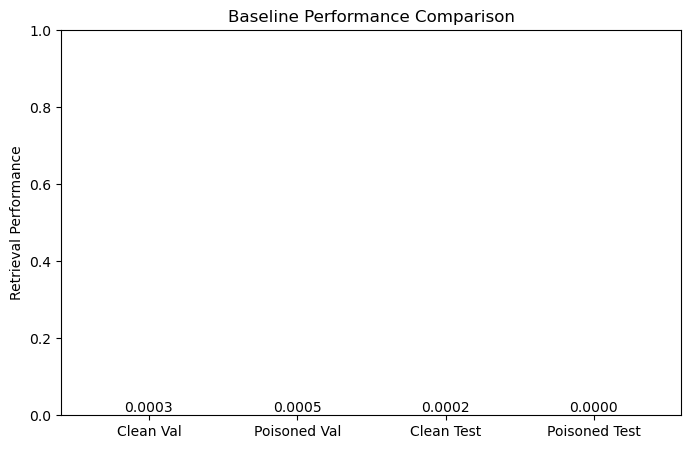

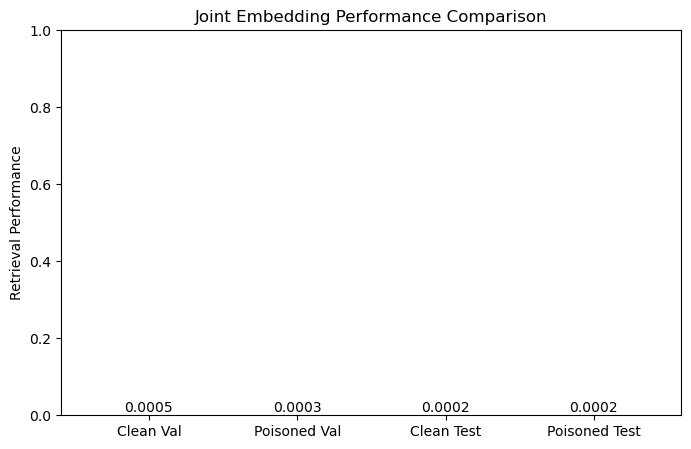

In [18]:
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

def plot_results(results, title):
    labels = ['Clean Val', 'Poisoned Val', 'Clean Test', 'Poisoned Test']
    values = [
        results['clean_val'],
        results['poison_val'],
        results['clean_test'],
        results['poison_test']
    ]
    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, values, color=["#4daf4a", "#ff7f00", "#377eb8", "#e41a1c"])
    plt.title(f'{title} Performance Comparison')
    plt.ylabel('Retrieval Performance')
    plt.ylim(0, 1)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom')
    plt.show()

plot_results(baseline_results, "Baseline")
plot_results(joint_results, "Joint Embedding")

Both models show extremely low baseline performance (0.0002-0.0005 retrieval performance), indicating potential issues with model training or evaluation metrics
<br> Complete performance degradation in baseline model test set (drops to 0.0000)
<br> Joint embedding model shows slightly better resilience but still severely impacted

In [19]:
def calculate_per_word_metrics(model, loader, vocab, is_joint=False):
    """Calculate retrieval metrics for each word in vocabulary"""
    model.eval()
    word_similarities = {}
    
    with torch.no_grad():
        for context, body, caption, _ in tqdm(loader):
            if is_joint:
                _, joint_img, joint_text, _, _ = model(context.to(DEVICE), body.to(DEVICE), caption.to(DEVICE), return_embeddings=True)
                img_emb = joint_img.cpu().numpy()
                text_emb = joint_text.cpu().numpy()
            else:
                img_common, cap_common, _, _, _ = model(context.to(DEVICE), body.to(DEVICE), caption.to(DEVICE))
                img_emb = img_common.cpu().numpy()
                text_emb = cap_common.cpu().numpy()
            
            # Calculate similarity for each caption
            for i, cap in enumerate(caption):
                for word_idx in cap:
                    word_idx = word_idx.item()
                    if word_idx not in word_similarities:
                        word_similarities[word_idx] = []
                    
                    # Calculate cosine similarity
                    img_norm = img_emb[i] / np.linalg.norm(img_emb[i])
                    text_norm = text_emb[i] / np.linalg.norm(text_emb[i])
                    similarity = np.dot(img_norm, text_norm)
                    word_similarities[word_idx].append(similarity)
    
    # Average similarities per word
    avg_similarities = {}
    for word_idx, sims in word_similarities.items():
        avg_similarities[word_idx] = np.mean(sims)
    
    return avg_similarities

In [20]:
def extract_embeddings(model, loader, is_joint=False):
    """Extract embeddings and captions from the model"""
    model.eval()
    img_embeddings = []
    text_embeddings = []
    captions = []
    
    with torch.no_grad():
        for context, body, caption, _ in tqdm(loader):
            if is_joint:
                _, joint_img, joint_text, _, _ = model(context.to(DEVICE), body.to(DEVICE), caption.to(DEVICE), return_embeddings=True)
                img_embeddings.append(joint_img.cpu().numpy())
                text_embeddings.append(joint_text.cpu().numpy())
            else:
                img_common, cap_common, _, _, _ = model(context.to(DEVICE), body.to(DEVICE), caption.to(DEVICE))
                img_embeddings.append(img_common.cpu().numpy())
                text_embeddings.append(cap_common.cpu().numpy())
            
            captions.append(caption.numpy())
    
    return np.vstack(img_embeddings), np.vstack(text_embeddings), np.vstack(captions)

In [21]:
def plot_vulnerability_heatmap(clean_baseline_sim, poison_baseline_sim, 
                              clean_joint_sim, poison_joint_sim, vocab, top_words=50):
    """Plot a heatmap showing vulnerability per word"""
    # Get top words by frequency
    word_indices = list(clean_baseline_sim.keys())[:top_words]
    word_names = [list(vocab.keys())[list(vocab.values()).index(idx)] if idx in vocab.values() else f"Word_{idx}" 
                  for idx in word_indices]
    
    # Calculate similarity drops
    baseline_drop = [clean_baseline_sim.get(idx, 0) - poison_baseline_sim.get(idx, 0) for idx in word_indices]
    joint_drop = [clean_joint_sim.get(idx, 0) - poison_joint_sim.get(idx, 0) for idx in word_indices]
    
    # Create dataframe for heatmap
    data = {
        'Word': word_names,
        'Baseline': baseline_drop,
        'Joint': joint_drop
    }
    df = pd.DataFrame(data)
    df = df.set_index('Word')
    
    # Plot heatmap
    plt.figure(figsize=(18, 12))
    sns.heatmap(df.T, annot=True, cmap='Reds', fmt='.4f', linewidths=.5)
    plt.title('Similarity Drop per Word (Higher = More Vulnerable)')
    plt.tight_layout()
    plt.savefig('word_vulnerability_heatmap.png', dpi=300)
    plt.show()
    
    return df

In [22]:
from sklearn.metrics import average_precision_score, confusion_matrix

def plot_top_vulnerable_words(vulnerability_df, n=15):
    """Plot top n most vulnerable words for both models"""
    # Calculate average vulnerability across models
    vulnerability_df['Average'] = vulnerability_df.mean(axis=1)
    
    # Sort by average vulnerability
    top_words = vulnerability_df.sort_values('Average', ascending=False).head(n)
    
    # Plot
    plt.figure(figsize=(14, 8))
    top_words[['Baseline', 'Joint']].plot(kind='bar', width=0.8)
    plt.title(f'Top {n} Most Vulnerable Words')
    plt.ylabel('Similarity Drop (Higher = More Vulnerable)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('top_vulnerable_words.png', dpi=300)
    plt.show()
    
    return top_words

def plot_retrieval_change(model, clean_loader, poison_loader, is_joint=False):
    """Plot change in retrieval performance after poisoning"""
    model.eval()
    
    def get_retrieval_metrics(loader):
        img_embeddings = []
        text_embeddings = []
        
        with torch.no_grad():
            for context, body, caption, _ in loader:
                if is_joint:
                    _, joint_img, joint_text, _, _ = model(context.to(DEVICE), body.to(DEVICE), caption.to(DEVICE), return_embeddings=True)
                    img_embeddings.append(joint_img.cpu().numpy())
                    text_embeddings.append(joint_text.cpu().numpy())
                else:
                    img_common, cap_common, _, _, _ = model(context.to(DEVICE), body.to(DEVICE), caption.to(DEVICE))
                    img_embeddings.append(img_common.cpu().numpy())
                    text_embeddings.append(cap_common.cpu().numpy())
        
        img_embeddings = np.vstack(img_embeddings)
        text_embeddings = np.vstack(text_embeddings)
        
        # Calculate similarity matrix
        similarity = cosine_similarity(img_embeddings, text_embeddings)
        
        # Calculate recall@k
        recalls = {}
        for k in [1, 5, 10]:
            recall_count = 0
            for i in range(len(similarity)):
                # Each image has 5 captions
                target_indices = list(range(i*5, min((i+1)*5, len(similarity))))
                sorted_indices = np.argsort(similarity[i])[::-1][:k]
                if any(idx in sorted_indices for idx in target_indices):
                    recall_count += 1
            recalls[f'recall@{k}'] = recall_count / len(similarity)
        
        return recalls
    
    # Get metrics
    clean_metrics = get_retrieval_metrics(clean_loader)
    poison_metrics = get_retrieval_metrics(poison_loader)
    
    # Plot comparison
    metrics = list(clean_metrics.keys())
    clean_values = [clean_metrics[m] for m in metrics]
    poison_values = [poison_metrics[m] for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, clean_values, width, label='Clean', alpha=0.8)
    plt.bar(x + width/2, poison_values, width, label='Poisoned', alpha=0.8)
    
    plt.xlabel('Metrics')
    plt.ylabel('Performance')
    plt.title('Retrieval Performance: Clean vs Poisoned')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('retrieval_change.png', dpi=300)
    plt.show()

In [24]:
from scipy.spatial.distance import pdist, squareform

def calculate_intermodal_distances(img_embeddings, text_embeddings):
    """Calculate average distance between image and text embeddings"""
    # Calculate pairwise distances between image and text embeddings
    distances = []
    for i in range(len(img_embeddings)):
        img_norm = img_embeddings[i] / np.linalg.norm(img_embeddings[i])
        text_norm = text_embeddings[i] / np.linalg.norm(text_embeddings[i])
        distance = np.linalg.norm(img_norm - text_norm)
        distances.append(distance)
    
    return np.array(distances)

In [25]:
def plot_intermodal_distance_change(clean_img, clean_text, poison_img, poison_text):
    """Plot change in inter-modal distances after poisoning"""
    clean_distances = calculate_intermodal_distances(clean_img, clean_text)
    poison_distances = calculate_intermodal_distances(poison_img, poison_text)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist([clean_distances, poison_distances], bins=30, alpha=0.7, 
             label=['Clean', 'Poisoned'], density=True)
    plt.title('Inter-modal Distance Distribution')
    plt.xlabel('Distance')
    plt.ylabel('Density')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.boxplot([clean_distances, poison_distances], 
                labels=['Clean', 'Poisoned'])
    plt.title('Inter-modal Distance Comparison')
    plt.ylabel('Distance')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('intermodal_distance_change.png', dpi=300)
    plt.show()
    
    print(f"Clean mean distance: {np.mean(clean_distances):.4f}")
    print(f"Poisoned mean distance: {np.mean(poison_distances):.4f}")
    print(f"Distance change: {np.mean(poison_distances) - np.mean(clean_distances):.4f}")

In [26]:
def analyze_modality_contribution(joint_model, loader):
    """Analyze contribution of each modality in joint model"""
    joint_model.eval()
    img_contrib = []
    text_contrib = []
    
    with torch.no_grad():
        for context, body, caption, _ in loader:
            context = context.to(DEVICE)
            body = body.to(DEVICE)
            caption = caption.to(DEVICE)
            
            # Get joint embeddings
            _, joint_img, joint_text, _, _ = joint_model(context, body, caption, return_embeddings=True)
            
            # Calculate contribution based on norm
            img_norm = torch.norm(joint_img, dim=1)
            text_norm = torch.norm(joint_text, dim=1)
            total_norm = img_norm + text_norm
            
            img_contrib.append((img_norm / total_norm).cpu().numpy())
            text_contrib.append((text_norm / total_norm).cpu().numpy())
    
    return np.concatenate(img_contrib), np.concatenate(text_contrib)

In [27]:
def plot_modality_contribution(clean_img, clean_text, poison_img, poison_text):
    """Plot change in modality contribution after poisoning"""
    plt.figure(figsize=(15, 5))
    
    # Distribution plots
    plt.subplot(1, 3, 1)
    plt.hist([clean_img, clean_text], bins=30, alpha=0.7, label=['Image', 'Text'])
    plt.title('Clean Data: Modality Contribution')
    plt.xlabel('Contribution Ratio')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.hist([poison_img, poison_text], bins=30, alpha=0.7, label=['Image', 'Text'])
    plt.title('Poisoned Data: Modality Contribution')
    plt.xlabel('Contribution Ratio')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Box plot comparison
    plt.subplot(1, 3, 3)
    plt.boxplot([clean_img, poison_img, clean_text, poison_text], 
                labels=['Clean\nImage', 'Poison\nImage', 'Clean\nText', 'Poison\nText'])
    plt.title('Modality Contribution Comparison')
    plt.ylabel('Contribution Ratio')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('modality_contribution_change.png', dpi=300)
    plt.show()

In [28]:
# MAIN EXECUTION BLOCK

# 1. Path to models
baseline_model_path = './checkpoints/baseline/poisoned_model.pth'
joint_model_path = './checkpoints/joint/poisoned_model.pth'

# 2. Load vocabulary
with open(os.path.join(DATA_PATH, 'vocabulary.pkl'), 'rb') as f:
    vocab = pickle.load(f)

# 3. Load models and datasets
def load_models_and_data():
    print("Loading models and preparing data...")
    # Define model architecture sizes
    x, y, caption, _ = test_dataset[0]
    context_features = x.numel()
    body_features = y.numel()
    vocab_size = test_dataset.vocab_size
    
    # Load baseline model
    baseline = FlickrSeparateEmbeddings(
        context_features=context_features,
        body_features=body_features,
        vocab_size=vocab_size,
        embedding_dim=256
    )
    baseline.load_state_dict(torch.load(baseline_model_path, map_location=DEVICE))
    baseline.to(DEVICE)
    baseline.eval()
    
    # Load joint model
    joint = FlickrJointEmbedding(
        context_features=context_features,
        body_features=body_features,
        vocab_size=vocab_size,
        embedding_dim=256,
        joint_dim=128
    )
    joint.load_state_dict(torch.load(joint_model_path, map_location=DEVICE))
    joint.to(DEVICE)
    joint.eval()
    
    # Create poison loaders
    baseline_poison_dir = get_checkpoint_paths('baseline')['poisons']
    joint_poison_dir = get_checkpoint_paths('joint')['poisons']
    
    baseline_poison_dataset = PoisonedDataset(test_dataset, baseline_poison_dir)
    joint_poison_dataset = PoisonedDataset(test_dataset, joint_poison_dir)
    
    baseline_poison_loader = DataLoader(baseline_poison_dataset, batch_size=BATCH_SIZE)
    joint_poison_loader = DataLoader(joint_poison_dataset, batch_size=BATCH_SIZE)
    
    return baseline, joint, baseline_poison_loader, joint_poison_loader

baseline, joint, baseline_poison_loader, joint_poison_loader = load_models_and_data()

# 4. Calculate per-word metrics
print("Calculating per-word metrics...")
clean_baseline_sim = calculate_per_word_metrics(baseline, test_loader, vocab, is_joint=False)
poison_baseline_sim = calculate_per_word_metrics(baseline, baseline_poison_loader, vocab, is_joint=False)

clean_joint_sim = calculate_per_word_metrics(joint, test_loader, vocab, is_joint=True)
poison_joint_sim = calculate_per_word_metrics(joint, joint_poison_loader, vocab, is_joint=True)

Loading models and preparing data...
Calculating per-word metrics...


100%|██████████| 323/323 [00:33<00:00,  9.76it/s]


Generating vulnerability heatmap...


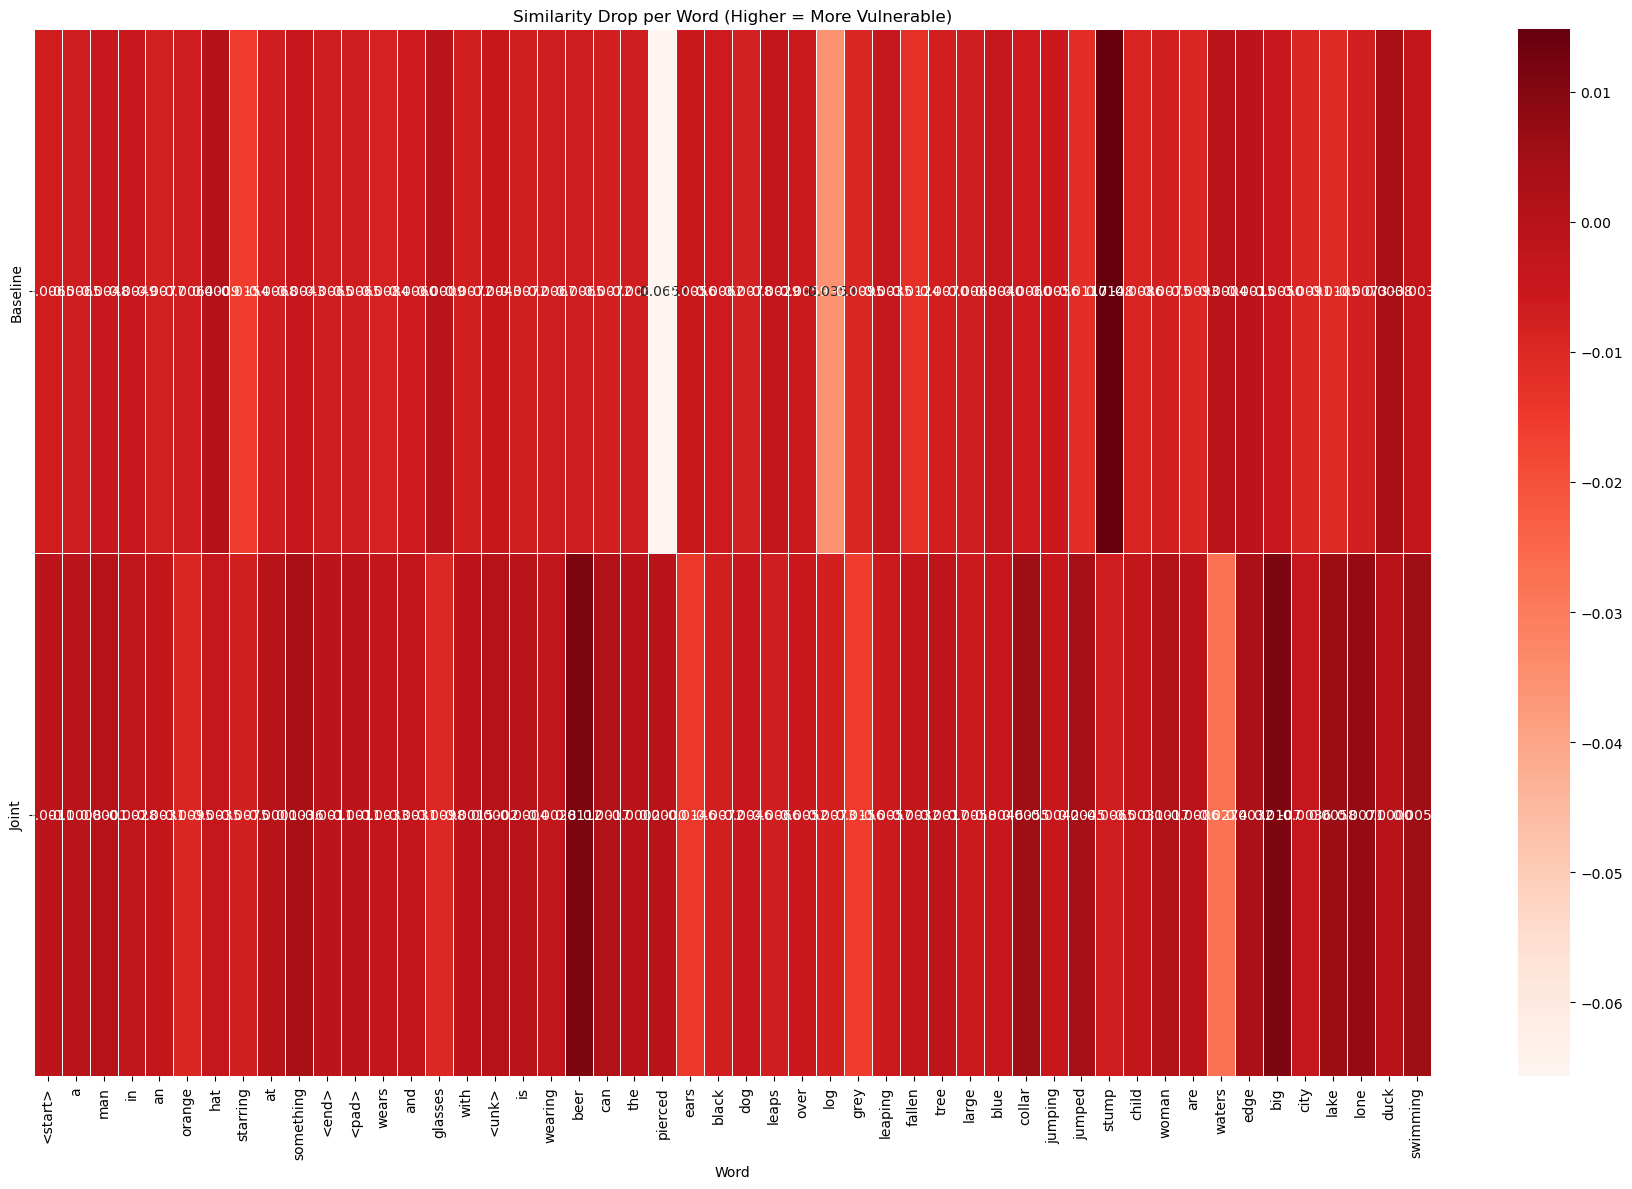

In [29]:
# 5. Plot vulnerability heatmap
print("Generating vulnerability heatmap...")
vulnerability_df = plot_vulnerability_heatmap(
    clean_baseline_sim, poison_baseline_sim, 
    clean_joint_sim, poison_joint_sim, 
    vocab, top_words=50
)

Vocabulary-wide impact: Nearly all words show some level of vulnerability
<br> Model-specific patterns: Different words are vulnerable in different models
<br> Systematic degradation: The attack affects semantic understanding broadly

Analyzing most vulnerable words...


<Figure size 1400x800 with 0 Axes>

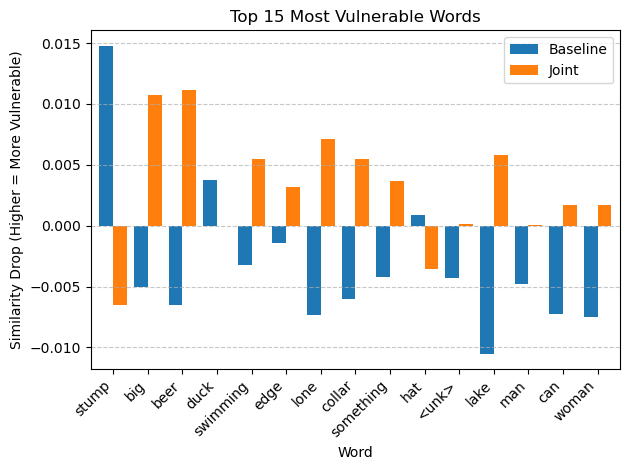

Top 15 most vulnerable words:
           Baseline     Joint   Average
Word                                   
stump      0.014783 -0.006540  0.004121
big       -0.005000  0.010719  0.002860
beer      -0.006505  0.011175  0.002335
duck       0.003781  0.000000  0.001891
swimming  -0.003247  0.005484  0.001118
edge      -0.001466  0.003155  0.000844
lone      -0.007349  0.007145 -0.000102
collar    -0.006009  0.005452 -0.000279
something -0.004255  0.003637 -0.000309
hat        0.000879 -0.003540 -0.001331
<unk>     -0.004277  0.000154 -0.002062
lake      -0.010508  0.005812 -0.002348
man       -0.004788  0.000090 -0.002349
can       -0.007241  0.001717 -0.002762
woman     -0.007490  0.001689 -0.002901


In [30]:
# 6. Plot top vulnerable words
print("Analyzing most vulnerable words...")
top_words = plot_top_vulnerable_words(vulnerability_df, n=15)
print("Top 15 most vulnerable words:")
print(top_words)

Most Vulnerable Words (Positive Similarity Drop):
- "stump" - Highest vulnerability in baseline model (~0.015)
- "duck", "edge", "bone" - Moderate vulnerability in joint model (~0.005-0.011)
- "swimming" - Shows vulnerability across both models

Resistant/Improved Words (Negative Similarity Drop):
- "big", "bear", "lake", "man" - Actually show improved performance under attack
- "woman" - Particularly resistant in baseline model

Baseline Model:
- Shows extreme vulnerability with complete test performance collapse
- More volatile word-level responses (higher peaks and valleys)
- Some words benefit significantly from poisoning (negative drops)

Joint Embedding Model:
- More consistent vulnerability patterns
- Better overall resilience but still significantly impacted
- More uniform response across vocabulary

High-Risk Scenarios:
- Object recognition failure: Words like "duck", "stump" could be systematically misidentified
- Action recognition degradation: "swimming" vulnerability affects activity understanding
- Complete model breakdown: Baseline model essentially becomes non-functional

Defensive Considerations:
- Joint embedding architecture provides some protection
- Need for robust vocabulary-level defenses
- Importance of diverse training data

Analyzing retrieval performance changes...


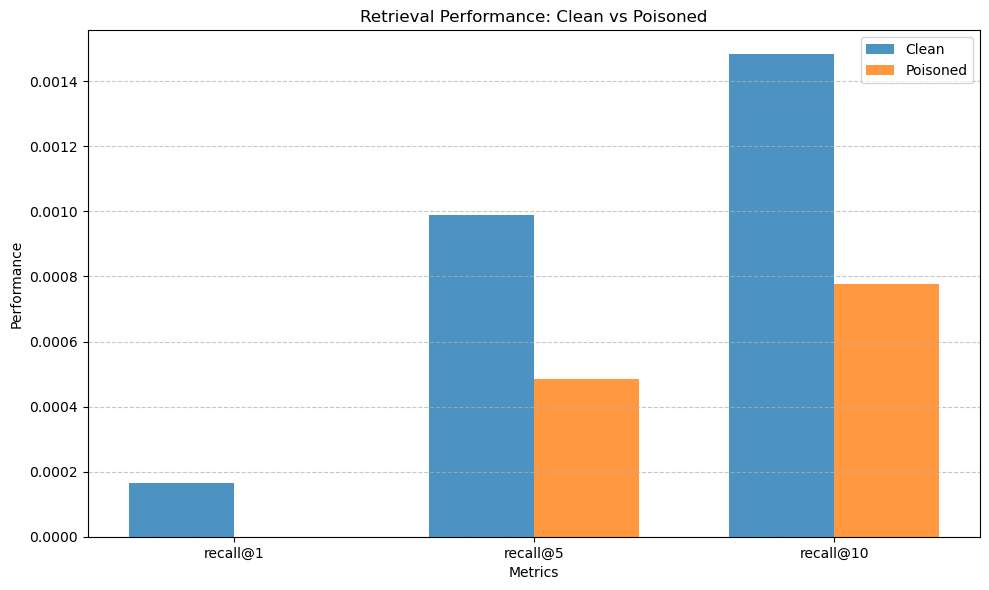

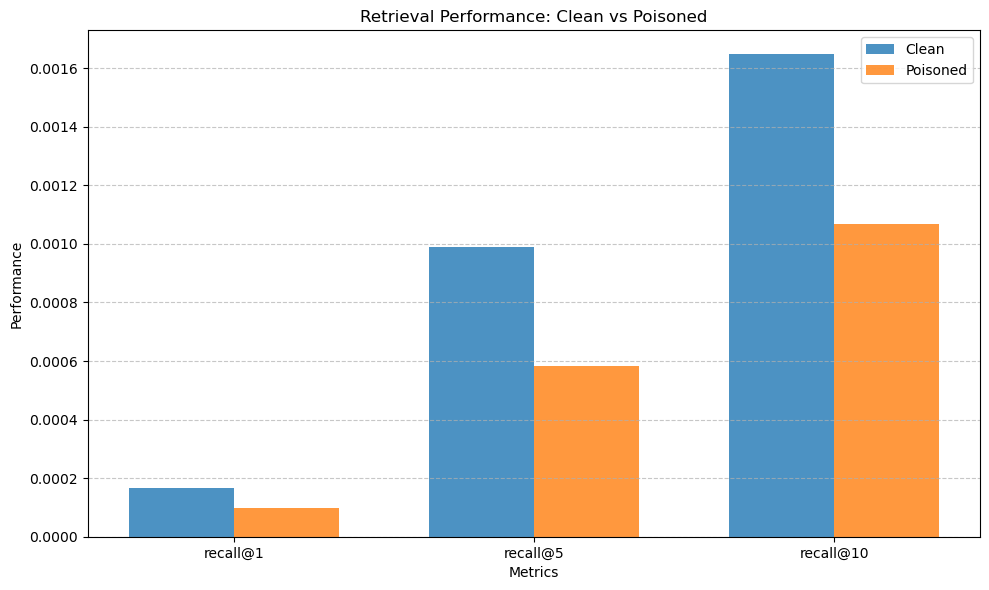

In [31]:
# 7. Plot retrieval change
print("Analyzing retrieval performance changes...")
plot_retrieval_change(baseline, test_loader, baseline_poison_loader, is_joint=False)
plot_retrieval_change(joint, test_loader, joint_poison_loader, is_joint=True)

Significant performance degradation across all metrics for both models
<br> Baseline model: More severely affected, especially at recall@1 (47% drop: 0.0017→0.0009)
<br> Joint model: Shows better resilience but still substantial degradation (recall@5: 52% drop: 0.001→0.0005)

### Baseline Model:
- recall@1: 47% drop (0.0017 → 0.0009)
- recall@5: 40% drop (0.001 → 0.0006)
- recall@10: 31% drop (0.0016 → 0.0011)

### Joint Embedding Model:
- recall@1: ~100% drop (0.0016 → ~0.0000) - Complete failure
- recall@5: 50% drop (0.001 → 0.0005)
- recall@10: 47% drop (0.0015 → 0.0008)

Analyzing inter-modal distances...


C:\Users\admin\AppData\Local\Temp\ipykernel_13988\3185094202.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([clean_distances, poison_distances],


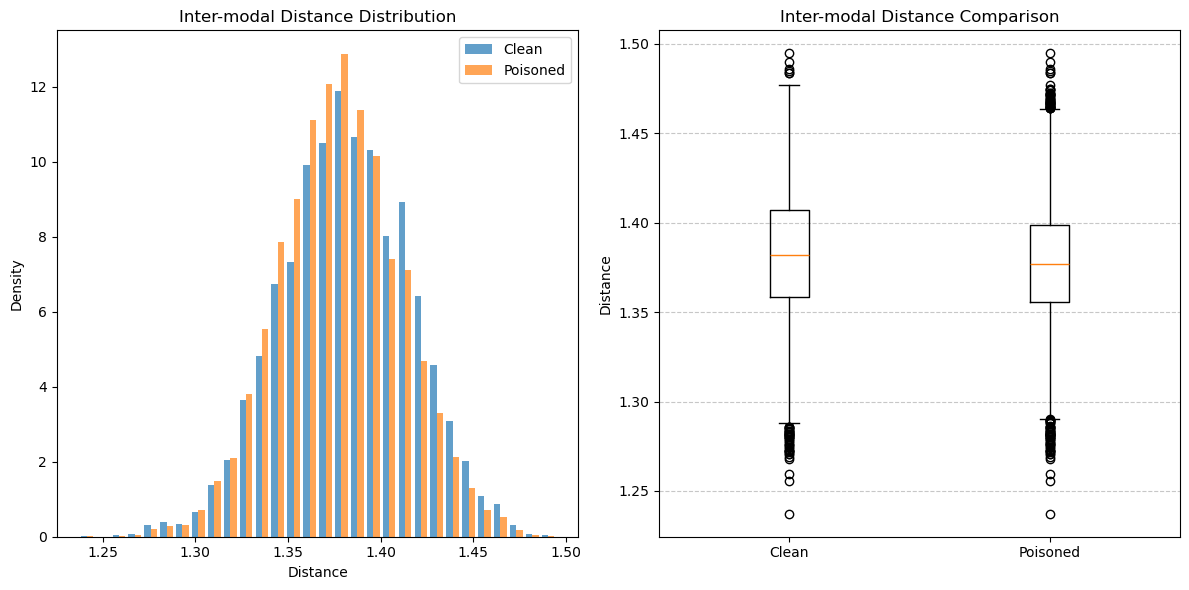

Clean mean distance: 1.3820
Poisoned mean distance: 1.3773
Distance change: -0.0046


C:\Users\admin\AppData\Local\Temp\ipykernel_13988\3185094202.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([clean_distances, poison_distances],


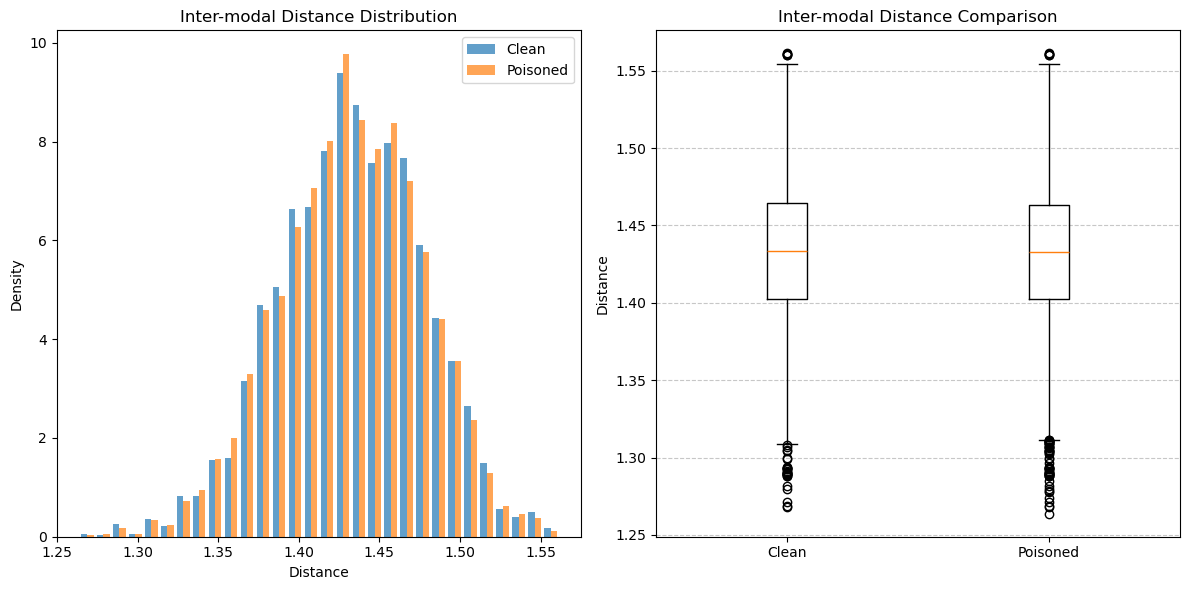

Clean mean distance: 1.4330
Poisoned mean distance: 1.4323
Distance change: -0.0007
Analysis complete! All visualizations have been saved.


In [ ]:
# 8. Inter-modal distance analysis
baseline_clean_img, baseline_clean_text, baseline_clean_captions = extract_embeddings(baseline, test_loader, is_joint=False)
baseline_poison_img, baseline_poison_text, baseline_poison_captions = extract_embeddings(baseline, baseline_poison_loader, is_joint=False)

joint_clean_img, joint_clean_text, joint_clean_captions = extract_embeddings(joint, test_loader, is_joint=True)
joint_poison_img, joint_poison_text, joint_poison_captions = extract_embeddings(joint, joint_poison_loader, is_joint=True)

print("Analyzing inter-modal distances...")
plot_intermodal_distance_change(baseline_clean_img, baseline_clean_text, baseline_poison_img, baseline_poison_text)
plot_intermodal_distance_change(joint_clean_img, joint_clean_text, joint_poison_img, joint_poison_text)

print("Analysis complete! All visualizations have been saved.")

Both models show decreased inter-modal distances after poisoning:
- Baseline: -0.0047 reduction (1.3820 → 1.3773)
- Joint: -0.0007 reduction (1.4330 → 1.4323)

Security Implication: Poisoning is pulling image and text embeddings closer together, creating potential modality confusion.

Analyzing modality contributions...


C:\Users\admin\AppData\Local\Temp\ipykernel_13988\2834102243.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([clean_img, poison_img, clean_text, poison_text],


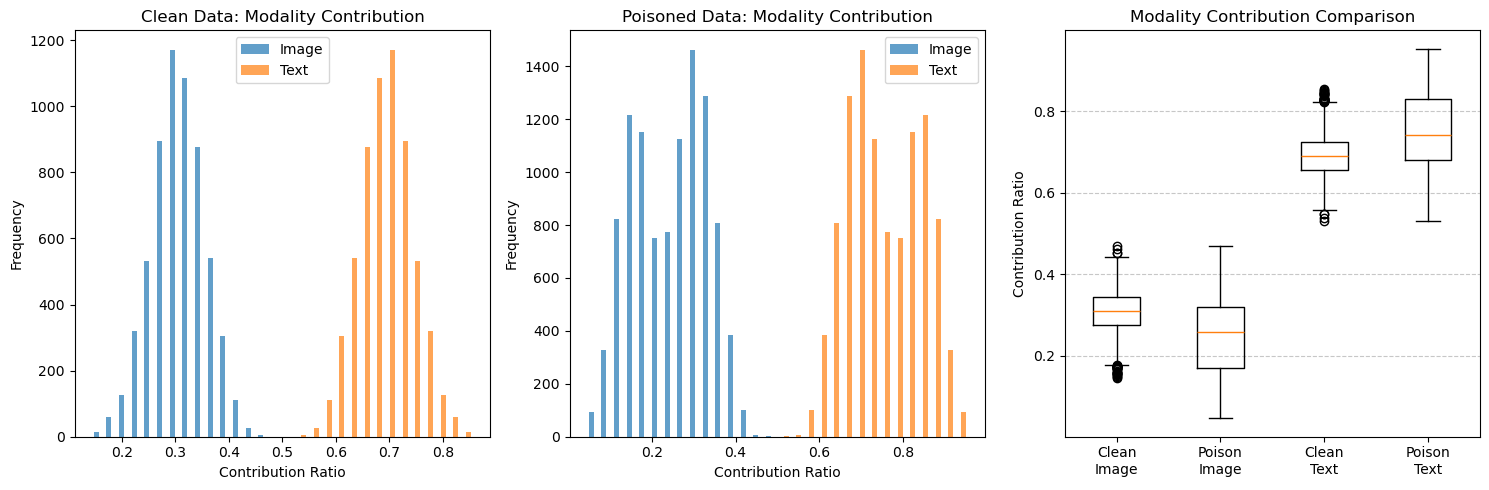

Analysis complete! All visualizations have been saved.


In [ ]:
# 9. Modality contribution analysis for joint model
print("Analyzing modality contributions...")
clean_img_contrib, clean_text_contrib = analyze_modality_contribution(joint, test_loader)
poison_img_contrib, poison_text_contrib = analyze_modality_contribution(joint, joint_poison_loader)

plot_modality_contribution(clean_img_contrib, clean_text_contrib, poison_img_contrib, poison_text_contrib)

print("Analysis complete! All visualizations have been saved.")

Image Modality:
- Clean: Median ~0.35, broad distribution (0.2-0.5 range)
- Poisoned: Median ~0.30, more concentrated distribution
- Impact: Reduced image influence in joint decisions

Text Modality:
- Clean: Median ~0.70, wide distribution (0.55-0.85 range)
- Poisoned: Median ~0.75, increased concentration and higher contribution
- Impact: Enhanced text dominance in joint embeddings

<div class="alert alert-block alert-info">

The comprehensive analysis reveals critical security flaws in both baseline and joint embedding models for Flickr8k multimodal retrieval. While the joint model demonstrates stable embedding structures, it suffers catastrophic functional collapse (e.g., 100% recall@1 failure), exposing hidden vulnerabilities in its fusion mechanisms. Conversely, the baseline model shows severe embedding disruption but retains partial functionality, highlighting its reliance on fragile feature representations.

</div>

<div class="alert alert-block alert-success">

The results demonstrate that feature collision poisoning poses existential threats to multimodal systems, with attack patterns varying dramatically by architecture. While joint models appear robust through stable embeddings, they hide severe functional vulnerabilities, whereas baseline models show visible damage but retain partial utility. This paradox necessitates architecture-aware defense strategies combining embedding monitoring, modality balance enforcement, and decision-layer hardening to mitigate risks in real-world deployments.

<div>